In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import emcee
from scipy.stats import norm
import corner

In [2]:
# Define the spectrum fitting file
df = pd.read_excel('spectral parameter J1655 R05.xlsx', sheet_name='bmc')

In [3]:
# Defines the normalization value and photon index (gamma)
bmc = df['norm_bmc'].to_numpy()
alpha = df['alpha'].to_numpy()
gamma = [a + 1 for a in df['alpha'].to_numpy()]

In [4]:
# Loop through the 'obs_id_cut' column and print each data point with its index
obs_id_cut = df.obs_id_cut
for i, obs_id in enumerate(obs_id_cut):
    print(f'Data point {i + 1}: obs_id_cut = {obs_id}')

Data point 1: obs_id_cut = 90058-16-02-00_16_0
Data point 2: obs_id_cut = 90058-16-02-00_16_1
Data point 3: obs_id_cut = 90058-16-02-00_16_2
Data point 4: obs_id_cut = 90058-16-03-00_16_0
Data point 5: obs_id_cut = 90058-16-03-00_16_1
Data point 6: obs_id_cut = 90058-16-03-00_16_2
Data point 7: obs_id_cut = 90058-16-04-00_16_0
Data point 8: obs_id_cut = 90058-16-04-00_16_1
Data point 9: obs_id_cut = 90058-16-04-00_16_2
Data point 10: obs_id_cut = 90428-01-01-00_16_0
Data point 11: obs_id_cut = 90428-01-01-00_16_1
Data point 12: obs_id_cut = 90428-01-01-00_16_2
Data point 13: obs_id_cut = 90428-01-01-00_16_3
Data point 14: obs_id_cut = 90428-01-01-00_16_4
Data point 15: obs_id_cut = 90428-01-01-00_16_5
Data point 16: obs_id_cut = 90428-01-01-00_16_6
Data point 17: obs_id_cut = 90428-01-01-00_16_7
Data point 18: obs_id_cut = 90428-01-01-00_16_8
Data point 19: obs_id_cut = 90428-01-01-00_16_10
Data point 20: obs_id_cut = 90428-01-01-00_16_11
Data point 21: obs_id_cut = 90428-01-01-00_16_1

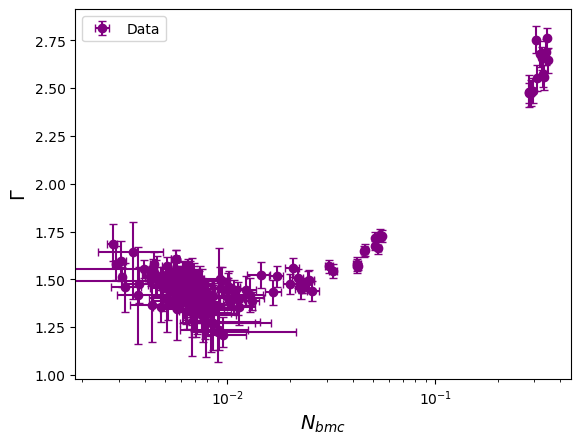

In [5]:
# Defines the error values from normalization and photon index
err_bmc_p = df['err_norm_bmc_p'].to_numpy()
err_bmc_m = df['err_norm_bmc_m'].to_numpy()  
err_gamma_p = df['err_alpha_p'].to_numpy()   
err_gamma_m = df['err_alpha_m'].to_numpy()   

# Plotting the data with error bars
plt.errorbar(bmc, gamma, 
             xerr=[np.abs(err_bmc_m), err_bmc_p], 
             yerr=[np.abs(err_gamma_m), err_gamma_p], 
             fmt='o', color='purple', capsize=3, label='Data')

# Configure plot appearance
plt.xscale('log')
plt.xlabel('$N_{bmc}$', fontsize=14)
plt.ylabel(r'$\Gamma$', fontsize=14)
plt.legend()
plt.show()

In [6]:
# Convert gamma (list) to a NumPy array for consistent indexing
gamma = np.array(gamma)

# Combine the mask to filter out NaN and inf values for bmc and gamma and their error
mask = (
    np.isfinite(bmc) & np.isfinite(gamma) &
    np.isfinite(err_bmc_m) & np.isfinite(err_bmc_p) &
    np.isfinite(err_gamma_m) & np.isfinite(err_gamma_p)
)

# Apply the mask to clean the data
bmc_clean = bmc[mask]
gamma_clean = gamma[mask]
err_bmc_m_clean = err_bmc_m[mask]
err_bmc_p_clean = err_bmc_p[mask]
err_gamma_m_clean = err_gamma_m[mask]
err_gamma_p_clean = err_gamma_p[mask]

In [7]:
# Define the scaling function
def scaling(Nbmc, A, B, Ntr, beta, D):
    return A - D * B * np.log(np.exp(1 - (Nbmc / Ntr)**beta) / D + 1)

# Define the log-likelihood function
def log_likelihood(theta, x, y, yerr_x, yerr_y):
    A, B, Ntr, beta, D = theta
    model = scaling(x, A, B, Ntr, beta, D)

    # Variance for likelihood
    sigma2 = yerr_y**2 + (B * (yerr_x / x))**2  
    chi2 = np.sum((y - model)**2 / sigma2)      
    return -0.5 * chi2, chi2

# Define the log-prior function (Gaussian priors)
def log_prior(theta):
    A, B, Ntr, beta, D = theta
    
    # Gaussian priors: mean, sigma 
    mu_A, sigma_A = 2.5, 0.2
    mu_B, sigma_B = 1.0, 0.3
    mu_Ntr, sigma_Ntr = 0.05, 0.01
    mu_beta, sigma_beta = 2.0, 0.5
    mu_D, sigma_D = 1.0, 0.3

    # Prior range 
    if not (0 < A < 4 and 0 < B < 2 and 0 < Ntr < 0.1 and 0 < beta < 5 and 0 < D < 3):
        return -np.inf

    # Gaussian log-prior
    lp_A = -0.5 * ((A - mu_A) / sigma_A)**2
    lp_B = -0.5 * ((B - mu_B) / sigma_B)**2
    lp_Ntr = -0.5 * ((Ntr - mu_Ntr) / sigma_Ntr)**2
    lp_beta = -0.5 * ((beta - mu_beta) / sigma_beta)**2
    lp_D = -0.5 * ((D - mu_D) / sigma_D)**2
    
    return lp_A + lp_B + lp_Ntr + lp_beta + lp_D

# Define the log-probability function
def log_probability(theta, x, y, yerr_x, yerr_y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    log_like, chi2 = log_likelihood(theta, x, y, yerr_x, yerr_y)
    return lp + log_like
    
# Set up MCMC parameters (number of dimensions, walkers, initial guess) and initialize walker positions with small random perturbations
ndim, nwalkers = 5, 50
initial_guess = [2.5, 1, 0.05, 2, 1]  # Initial guess
pos = [initial_guess + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]

# Run the MCMC
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,
    args=(bmc_clean, gamma_clean, err_bmc_m_clean, err_gamma_m_clean)
)
sampler.run_mcmc(pos, 100000, progress=True)

# Get the samples and remove burn-in
samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Calculate the best-fit parameters and uncertainties
A_mcmc, B_mcmc, Ntr_mcmc, beta_mcmc, D_mcmc = map(
    lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
    zip(*np.percentile(samples, [16, 50, 84], axis=0))
)

# Print the best-fit MCMC parameter values
print("A =", A_mcmc)
print("B =", B_mcmc)
print("Ntr =", Ntr_mcmc)
print("beta =", beta_mcmc)
print("D =", D_mcmc)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:12<00:00, 180.93it/s]

A = (2.596839857399035, 0.018712976112263302, 0.017702989499204236)
B = (1.8709947002299216, 0.09135405378765515, 0.14855202300285897)
Ntr = (0.06667658478257034, 0.0035549941994710427, 0.002786338116603629)
beta = (2.551456818594642, 0.37038872664547906, 0.36307492291862253)
D = (0.23766820504427172, 0.034035062695536134, 0.01830528236471643)


In [8]:
# Print MCMC diagnostics: mean acceptance fraction and mean autocorrelation time
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print("Mean autocorrelation time: {0:.3f}".format(np.mean(sampler.get_autocorr_time())))

Mean acceptance fraction: 0.476
Mean autocorrelation time: 157.107


In [9]:
# Extract flattened MCMC samples and save selected parameters 
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
np.savetxt("samples GRO R05 50.txt".format(df['obs_id'][0]), np.c_[flat_samples[:, 0],flat_samples[:, 1],flat_samples[:, 2]])

In [10]:
# Calculate reduced chi-squared
final_params = samples[-1]
chi2_final = log_likelihood(final_params, bmc_clean, gamma_clean, err_bmc_m_clean, err_gamma_m_clean)[1]
dof = len(bmc_clean) - len(final_params)  # Number of data points minus number of parameters
reduced_chi2 = chi2_final / dof

# Generate a smooth bmc normalization range for the fitted curve
Nbmc_fit = np.logspace(np.log10(min(bmc_clean)), np.log10(max(bmc_clean)), 1000)

# Calculate the fitted scaling function using MCMC parameters
gamma_fit = scaling(Nbmc_fit, A_mcmc[0], B_mcmc[0], Ntr_mcmc[0], beta_mcmc[0], D_mcmc[0])

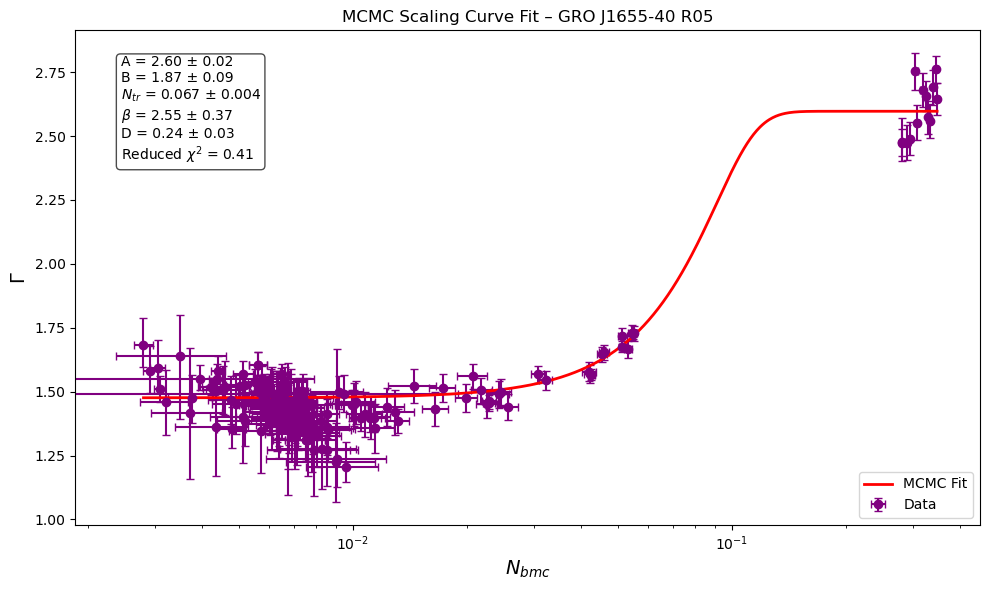

In [11]:
# Plotting the data and the fit
plt.figure(figsize=(10, 6))

# Scatter plot with error bars
plt.errorbar(bmc_clean, gamma_clean, 
             xerr=[np.abs(err_bmc_m_clean), err_bmc_m_clean], 
             yerr=[np.abs(err_gamma_m_clean), err_gamma_p_clean], 
             fmt='o', color='purple', capsize=3, label='Data')

# MCMC fitted curve
plt.plot(Nbmc_fit, gamma_fit, color='red', label='MCMC Fit', lw=2)

# Log scale for x-axis
plt.xscale('log')
plt.xlabel('$N_{bmc}$', fontsize=14)
plt.ylabel(r'$\Gamma$', fontsize=14)

# Add a text box with fitted parameters
param_text = (f'A = {A_mcmc[0]:.2f} ± {A_mcmc[1]:.2f}\n'
              f'B = {B_mcmc[0]:.2f} ± {B_mcmc[1]:.2f}\n'
              f'$N_{{tr}}$ = {Ntr_mcmc[0]:.3f} ± {Ntr_mcmc[1]:.3f}\n'
              f'$\\beta$ = {beta_mcmc[0]:.2f} ± {beta_mcmc[1]:.2f}\n'
              f'D = {D_mcmc[0]:.2f} ± {D_mcmc[1]:.2f}\n'
              f'Reduced $\\chi^2$ = {reduced_chi2:.2f}')
plt.text(0.05, 0.95, param_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Add Title, legend and show plot
plt.title('MCMC Scaling Curve Fit – GRO J1655-40 R05')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

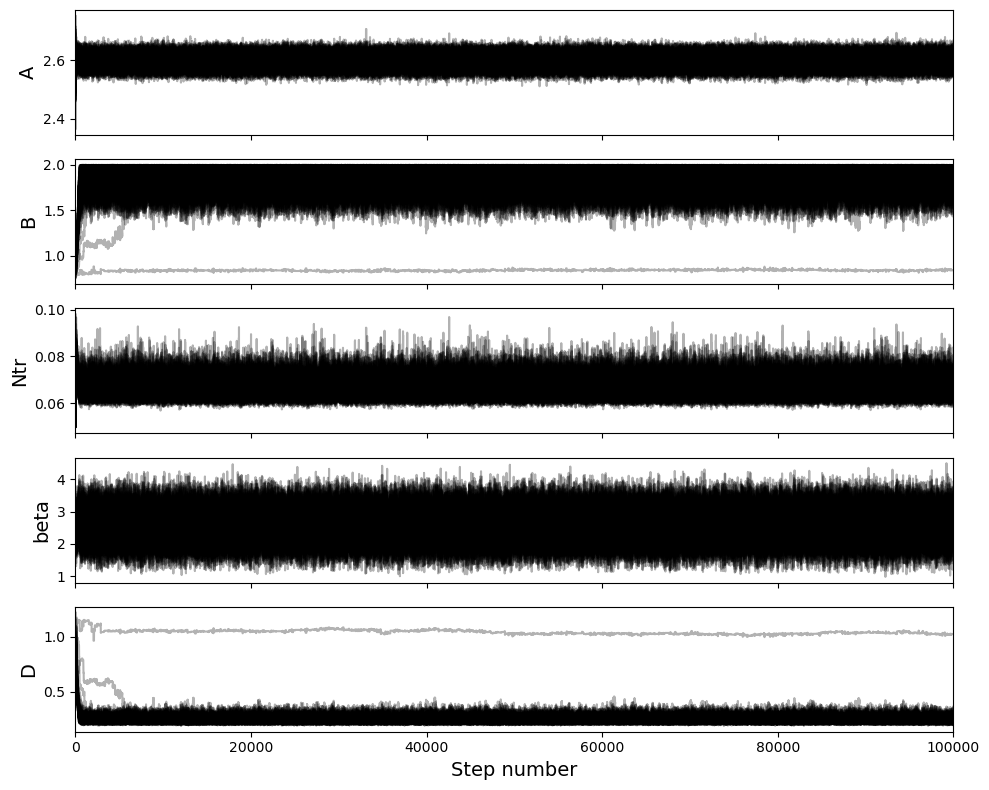

In [12]:
# Update the number of dimensions and labels to include D
ndim = 5  # number of parameters
labels = ["A", "B", "Ntr", "beta", "D"] 

# Plot the trace for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 8), sharex=True)
samples_full = sampler.get_chain()  # Get the full chain without thinning or discarding burn-in

# Plot each parameter's trace
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_full[:, :, i], "k", alpha=0.3)  # Plot each walker's chain in light black
    ax.set_xlim(0, samples_full.shape[0]) 
    ax.set_ylabel(labels[i], fontsize=14)  

# Label the x-axis of the last plot
axes[-1].set_xlabel("Step number", fontsize=14)

# Tight layout for clean display
plt.tight_layout()
plt.show()

MCMC Results:
A = 2.597 +0.019 -0.018
B = 1.871 +0.091 -0.149
Ntr = 0.067 +0.004 -0.003
beta = 2.551 +0.370 -0.363
D = 0.238 +0.034 -0.018
Reduced Chi-squared = 0.41


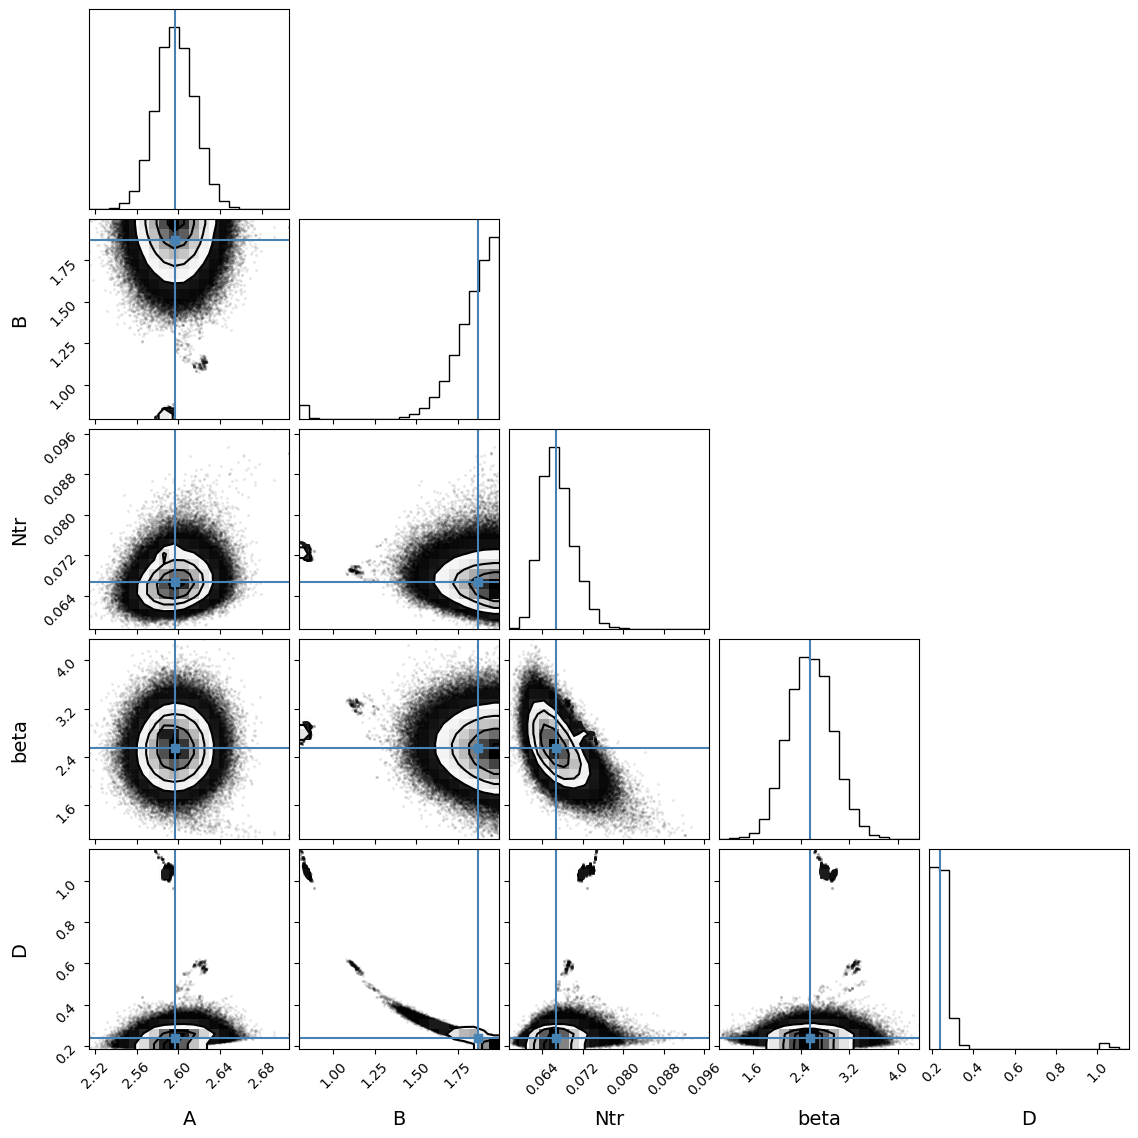

In [13]:
# Create corner plot
fig = corner.corner(
    samples,
    labels=["A", "B", "Ntr", "beta", "D"],
    truths=[A_mcmc[0], B_mcmc[0], Ntr_mcmc[0], beta_mcmc[0], D_mcmc[0]],
    label_kwargs={"fontsize": 14},
    title_kwargs={"fontsize": 14},
    tick_kwargs={"labelsize": 12}
)
plt.savefig(f'Corner plot GRO R05.jpg', bbox_inches='tight', dpi=300)


# Print the MCMC results and reduced chi-squared
print("MCMC Results:")
print(f"A = {A_mcmc[0]:.3f} +{A_mcmc[1]:.3f} -{A_mcmc[2]:.3f}")
print(f"B = {B_mcmc[0]:.3f} +{B_mcmc[1]:.3f} -{B_mcmc[2]:.3f}")
print(f"Ntr = {Ntr_mcmc[0]:.3f} +{Ntr_mcmc[1]:.3f} -{Ntr_mcmc[2]:.3f}")
print(f"beta = {beta_mcmc[0]:.3f} +{beta_mcmc[1]:.3f} -{beta_mcmc[2]:.3f}")
print(f"D = {D_mcmc[0]:.3f} +{D_mcmc[1]:.3f} -{D_mcmc[2]:.3f}")  
print(f"Reduced Chi-squared = {reduced_chi2:.2f}")

In [15]:
# Compute the fitted scaling function with MCMC parameters and save observed/cleaned data with the fit results 
gamma_f = scaling(bmc_clean, A_mcmc[0], B_mcmc[0], Ntr_mcmc[0], beta_mcmc[0], D_mcmc[0])
np.savetxt('mcmc GRO R05 fit 50.txt', np.c_[gamma_clean, err_gamma_p_clean, err_gamma_m_clean, bmc_clean, err_bmc_p_clean, err_bmc_m_clean, gamma_f], fmt='% 1.3f', header=' gamma err_gamma_p err_gamma_m bmc err_bmc_p err_bmc_m gamma_fit')